# Library

In [2]:
import itertools
import functools

import math

import numpy as np
import pandas as pd

import pyreadr

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import cm
import seaborn as sns

from scipy.spatial.distance import pdist, squareform

# import umap
# import umap.plot

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
import requests

# Data loading

In [3]:
clean_data = pyreadr.read_r('./data/training/absolute_dataset._clean_.RData')['absolute_dataset']
prot_matr_fc = pyreadr.read_r('./data/training/proteins.matrix.sva.0.5.1.FC.RData')['proteins.matrix.sva.0.5.1.FC']
prot_matr = pyreadr.read_r('./data/training/proteins.matrix.sva.0.5.1.RData')['proteins.matrix.sva.0.5.1']
orf2name = pyreadr.read_r('./data/training/orf2name._clean_.RData')['orf2name']
exp_metadata = pyreadr.read_r('./data/training/exp_metadata._clean_.RData')['exp_metadata']

# yeat metabolic model
imm904 = pyreadr.read_r('./data/training/iMM904._load_.RData')['iMM904']

metabolite_order = pd.read_csv('./data/training/metabolites.txt', delimiter='\t')
metabolie2imm904 = pyreadr.read_r('./data/training/metabolite2iMM904._load_.RData')['metabolite2iMM904']
gene_annotation = pyreadr.read_r('./data/training/gene.annotations._load_.RData')['gene.annotations']
go = pyreadr.read_r('./data/training/GO.raw._load_.RData')['GO.raw']

# brenda
brenda = pd.read_csv('./data/training/brenda.txt', delimiter='\t')

# metabolite data
tca_dataset = pyreadr.read_r('./data/training/dataTCA.create_datasets.RData')
aa_dataset = pyreadr.read_r('./data/training/dataAA.create_datasets.RData')

# models data
final_models_data = pyreadr.read_r('./data/training/all_final_models.models.data_prep.RData')['all_final_models.models']
prep_models_data = pyreadr.read_r('./data/training/all_linear_models.data_prep.RData')['all_linear_models']

# intervals
prediction_intervals = pyreadr.read_r('./data/training/prediction.intervals.data_prep.RData')['prediction.intervals']
prediction_models = pyreadr.read_r('./data/training/prediction.models.data_prep.RData')['prediction.models']

# raw
raw_metabolites = pd.read_csv('./data/training/metabolites_dataset.data_prep.tsv', delimiter='\t')
raw_proteins = pd.read_csv('./data/training/proteins_dataset.data_prep.tsv', delimiter='\t')

: 

: 

In [16]:
from typing import Dict, Any

def get_context(gene_id: str) -> requests.Response:
    output_format = "tsv-no-header"
    specie_id = 4932

    url = f"https://string-db.org/api/{output_format}/network?identifiers={gene_id}"
    params = {
        "identifiers": gene_id,
        "species": specie_id
    }

    return requests.post(url, params)

def get_functional_annotation(gene_id: str) -> requests.Response:
    output_format = "json"
    specie_id = 4932

    url = f"https://string-db.org/api/{output_format}/functional_annotation?identifiers={gene_id}"
    params = {
        "identifiers": gene_id,
        "species": specie_id
    }

    return requests.post(url, params)

def transform_response(json_response: requests.Response) -> Dict[str, Any]:
    return {
        "gene_prefered_name": json_response[0]['preferredNames'],
        "go_terms": [resp['term'] for resp in json_response],
        "categories": [resp['category'] for resp in json_response],
        "description": [resp['description'] for resp in json_response]
    }

In [21]:
gene_context = [get_context(gene_id) for gene_id in prot_matr_fc['ORF'].unique()[:10]]
gene_functional_annotation = [get_functional_annotation(gene_id) for gene_id in prot_matr_fc['ORF'].unique()[:10]]

tsv_records = [ 
    {
        "gene_id": gene_id,
        "interaction_network": text 
    }
    for gene_id, response in zip(prot_matr_fc['ORF'].unique()[:10], gene_context)
    if 'Error' not in (text := response.text)
]

functional_records = {
    gene_id: transform_response(json_response)
    for gene_id, response in zip(prot_matr_fc['ORF'].unique()[:10], gene_functional_annotation)
    if (json_response := response.json()) and len(json_response) > 0 and response.status_code == 200
}


In [25]:
functional_records['YAL003W'].keys()


dict_keys(['gene_prefered_name', 'go_terms', 'categories', 'description'])

# Paper reproduction

In [7]:
RHS = raw_proteins.groupby(by=['KO_ORF', 'ORF'])['value'].mean().to_frame().pivot_table(index='KO_ORF', columns='ORF', values='value')
LHS = raw_metabolites.pivot_table(index='genotype', columns='metabolite_id', values='value')
LHS.reset_index().merge(RHS, left_on='genotype', right_on='KO_ORF').set_index('genotype')
LHS

metabolite_id,3pg;2pg,6pgc,accoa,adp,akg,ala-L;ala-B,amp,arg-L,asn-L,asp-L,...,ru5p-D,s7p,ser-L,succ,thr-L,trp-L,tyr-L,val-L,xu5p-D,xu5p-D;ru5p-D
genotype,,,,,,,,,,,,,,,,,,,,,
WT,425.328812,173.986512,4.820485,NaN,10.377185,148.374767,NaN,171.119990,30.131845,169.702219,...,0.409042,474.343120,77.775874,1.750759,74.283400,0.288332,18.763970,25.710816,18.365667,921.058392
YAL017W,151.279057,60.629036,4.187382,NaN,11.189301,NaN,NaN,NaN,NaN,NaN,...,0.408033,262.470370,NaN,2.068443,NaN,NaN,NaN,NaN,19.463005,951.437296
YAR018C,196.478799,96.809625,4.654009,NaN,11.734239,NaN,NaN,NaN,NaN,NaN,...,0.601457,290.574555,NaN,5.067408,NaN,NaN,NaN,NaN,25.395322,882.991924
YBL016W,668.226067,341.434241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,727.906677,NaN,NaN,NaN,NaN,NaN,NaN,NaN,654.096269
YBL088C,130.446867,69.913588,3.701013,NaN,10.349731,163.073977,NaN,177.408777,28.073611,181.477538,...,0.467538,236.430595,77.280230,2.458696,76.941572,0.326089,19.177214,25.213202,18.814895,604.834183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YPL150W,584.790730,319.802626,NaN,15204.676363,NaN,NaN,3170.669200,NaN,NaN,NaN,...,NaN,826.079177,NaN,NaN,NaN,NaN,NaN,NaN,NaN,832.049003
YPL203W,987.269563,467.852082,NaN,18660.682062,NaN,NaN,4025.363605,NaN,NaN,NaN,...,NaN,936.483609,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1100.669747
YPL236C,872.368314,398.396387,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,804.918126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,755.057198


In [8]:
precursor_metabolite_ids = [
    'g6p;g6p-B',
    'g6p;f6p;g6p-B',
    'f6p',
    'dhap',
    '3pg;2pg',
    'pep',
    'pyr',
    'r5p',
    'e4p',
    'accoa',
    'akg',
    'oaa',
]

## Figure 2 reproduction

In [11]:
prot_matr_fc

,ORF,contrasts,logFC,p.value,p.value_BH,p.value_bonferroni,KO,reference
0,YAL003W,YAL017W-WT,-0.010358,9.385992e-01,9.614959e-01,1.000000e+00,YAL017W,WT
1,YAL003W,YAR018C-WT,0.107609,4.238359e-01,5.598622e-01,1.000000e+00,YAR018C,WT
2,YAL003W,YBL016W-WT,-0.128634,3.391701e-01,4.753336e-01,1.000000e+00,YBL016W,WT
3,YAL003W,YBL088C-WT,0.015310,9.093521e-01,9.434310e-01,1.000000e+00,YBL088C,WT
4,YAL003W,YBR028C-WT,-0.090297,5.020695e-01,6.316246e-01,1.000000e+00,YBR028C,WT
...,...,...,...,...,...,...,...,...
70417,YPR191W,YPL150W-WT,-1.034235,1.029964e-42,9.298991e-40,7.253213e-38,YPL150W,WT
70418,YPR191W,YPL203W-WT,-0.455013,4.247577e-12,8.782233e-11,2.991228e-07,YPL203W,WT
70419,YPR191W,YPL236C-WT,-1.047854,1.724073e-43,1.759604e-40,1.214127e-38,YPL236C,WT
70420,YPR191W,YPR106W-WT,-0.483696,2.378962e-13,5.976856e-12,1.675313e-08,YPR106W,WT


In [10]:
_df = prot_matr_fc[
    (prot_matr_fc['KO'].isin(exp_metadata[exp_metadata['type'] == 'Kinase']['ORF'].unique())) &
    (prot_matr_fc['ORF']).isin(imm904['gene']) &
    (prot_matr_fc['p.value_BH']  < 0.01) &
    (abs(prot_matr_fc['logFC']) > math.log2(1.4/0.714))
]

_df = _df.merge(orf2name[['ORF', 'gene_name']], left_on='KO', right_on='ORF', suffixes=(None, '_right'))

# prot_matr_fc[prot_matr_fc['gene_name'] == 'KDX1']
_df

,ORF,contrasts,logFC,p.value,p.value_BH,p.value_bonferroni,KO,reference,ORF_right,gene_name
0,YAL038W,YER129W-WT,-1.165160,1.157484e-40,8.151235e-38,8.151235e-36,YER129W,WT,YER129W,SAK1
1,YBR115C,YER129W-WT,-1.447165,2.172409e-04,9.925094e-04,1.000000e+00,YER129W,WT,YER129W,SAK1
2,YBR221C,YER129W-WT,-1.034736,8.353716e-22,7.087776e-20,5.882854e-17,YER129W,WT,YER129W,SAK1
3,YGL008C,YER129W-WT,-1.270291,7.553802e-12,1.502270e-10,5.319538e-07,YER129W,WT,YER129W,SAK1
4,YGR208W,YER129W-WT,1.038642,3.616926e-05,2.012095e-04,1.000000e+00,YER129W,WT,YER129W,SAK1
...,...,...,...,...,...,...,...,...,...,...
1225,YGR192C,YLL019C-WT,-1.275514,1.077783e-04,5.323677e-04,1.000000e+00,YLL019C,WT,YLL019C,KNS1
1226,YJL153C,YLL019C-WT,-1.156183,7.472814e-15,2.334740e-13,5.262505e-10,YLL019C,WT,YLL019C,KNS1
1227,YKL181W,YAL017W-WT,0.984922,3.133475e-04,1.369148e-03,1.000000e+00,YAL017W,WT,YAL017W,PSK1
1228,YMR105C,YNR047W-WT,-1.200005,6.078813e-10,8.855651e-09,4.280822e-05,YNR047W,WT,YNR047W,FPK1


In [6]:
upr_genes = prot_matr_fc[prot_matr_fc['logFC'] > 0]
downr_genes = prot_matr_fc[prot_matr_fc['logFC'] < 0]

wide_full = prot_matr_fc.pivot_table(index=['KO', 'gene_name'], columns='ORF', values='logFC').fillna(0).sort_values(by=['gene_name'])
wide_full[wide_full != 0] = 1

wide_upr = upr_genes.pivot_table(index=['KO', 'gene_name'], columns='ORF', values='logFC').fillna(0).sort_values(by=['gene_name'])
wide_upr[wide_upr != 0] = 1

wide_downr = downr_genes.pivot_table(index=['KO', 'gene_name'], columns='ORF', values='logFC').fillna(0).sort_values(by=['gene_name'])
wide_downr[wide_downr != 0] = 1

wide_upr

,ORF,YAL044C,YBL064C,YBR035C,YBR205W,YCL009C,YCL050C,YCR005C,YDL100C,YDR074W,YDR098C,...,YLR438W,YML022W,YMR215W,YMR300C,YOL030W,YOR095C,YPL262W,YPR035W,YPR062W,YPR145W
KO,gene_name,,,,,,,,,,,,,,,,,,,,,
YBR059C,AKL1,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
YGL021W,ALK1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
YNL020C,ARK1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
YJL095W,BCK1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
YGR188C,BUB1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YHR135C,YCK1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
YNL154C,YCK2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
YOL128C,YGK3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
wide_index = wide_full.index.get_level_values('gene_name')
upr_index = wide_upr.index.get_level_values('gene_name')
downr_index = wide_downr.index.get_level_values('gene_name')

In [8]:
metric = 'jaccard'

wide_full_dist = 1 - squareform(pdist(wide_full.values, metric=metric))
wide_upr_dist = 1 - squareform(pdist(wide_upr.values, metric=metric))
wide_downr_dist = 1 - squareform(pdist(wide_downr.values, metric=metric))

print(f'{wide_full_dist.shape=} \n{wide_upr_dist.shape=} \n{wide_downr_dist.shape=}')

proj_wide_upr_dist = np.zeros(wide_full_dist.shape)
mask = np.array(np.where(np.in1d(wide_index, upr_index))[0])
proj_wide_upr_dist[mask[:, np.newaxis], mask] = wide_upr_dist

proj_wide_downr_dist = np.zeros(wide_full_dist.shape)
mask = np.array(np.where(np.in1d(wide_index, downr_index))[0])
proj_wide_downr_dist[mask[:, np.newaxis], mask] = wide_downr_dist

zeros = np.zeros(shape=wide_full_dist.shape)
zeros[np.logical_not(np.tri(*zeros.shape, dtype=np.bool_))] = proj_wide_upr_dist[np.logical_not(np.tri(*zeros.shape, dtype=np.bool_))]
zeros[np.tri(*zeros.shape, dtype=np.bool_)] = proj_wide_downr_dist[np.tri(*zeros.shape, dtype=np.bool_)] * -1

wide_full_dist.shape=(94, 94) 
wide_upr_dist.shape=(79, 79) 
wide_downr_dist.shape=(93, 93)


[[0.01960784 0.18823529 0.38039216 1.        ]
 [0.18431373 0.47266436 0.71164937 1.        ]
 [0.51787774 0.73794694 0.85190311 1.        ]
 [0.86051519 0.91741638 0.94871203 1.        ]
 [0.98477509 0.89327182 0.83944637 1.        ]
 [0.94071511 0.60991926 0.48127643 1.        ]
 [0.76170704 0.22145329 0.22875817 1.        ]
 [0.40392157 0.         0.12156863 1.        ]]
[[0.01960784 0.18823529 0.38039216 1.        ]
 [0.18431373 0.47266436 0.71164937 1.        ]
 [0.51787774 0.73794694 0.85190311 1.        ]
 [1.         1.         1.         1.        ]
 [1.         1.         1.         1.        ]
 [0.94071511 0.60991926 0.48127643 1.        ]
 [0.76170704 0.22145329 0.22875817 1.        ]
 [0.40392157 0.         0.12156863 1.        ]]


<AxesSubplot:>

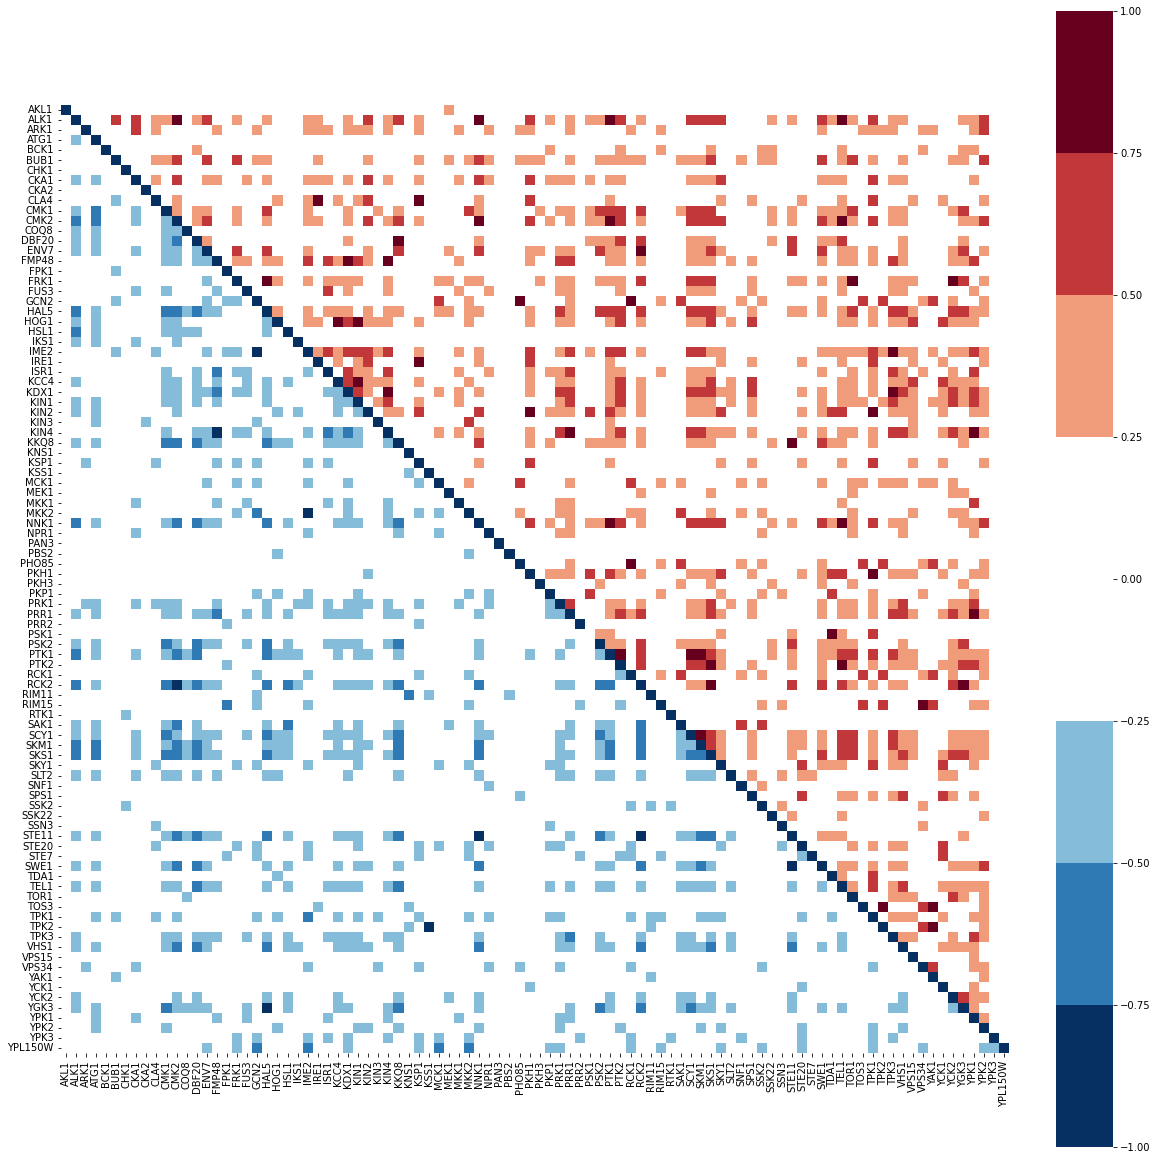

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(16, 16), constrained_layout=True)

bounds = np.linspace(-1, 1, 9)
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)

cmap = cm.get_cmap('RdBu_r', 256)
cmap = cmap(norm(bounds[:-1]))
print(cmap)
cmap[3] = [1,1,1,1]
cmap[4] = [1,1,1,1]
# print(cmap(norm.boundaries))
print(cmap)

colors.ListedColormap(cmap)

sns.heatmap(
    zeros,
    cbar=True,
    ax=ax,
    square=True,
    cmap=colors.ListedColormap(cmap),
    # norm=norm,
    xticklabels=wide_full.index.get_level_values('gene_name').tolist(),
    yticklabels=wide_full.index.get_level_values('gene_name').tolist()
)

# pcm = ax.pcolor(zeros, norm=norm, cmap='RdBu_r')
# # The colorbar inherits the "extend" argument from BoundaryNorm.
# fig.colorbar(pcm, ax=ax, orientation='vertical')
# ax.set_title('BoundaryNorm: extend="both"')
# plt.show()

## Figure 4 reporduction

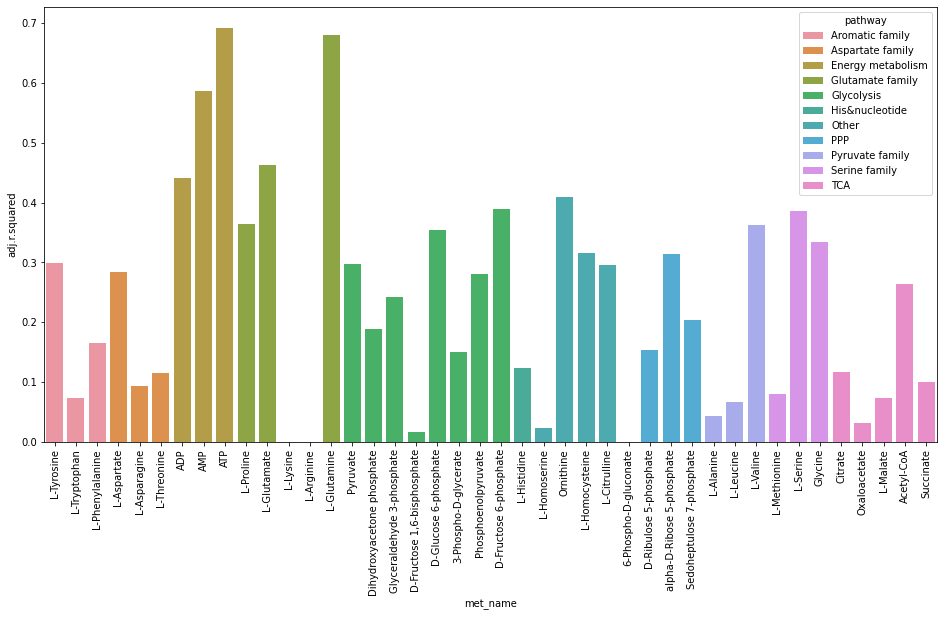

In [10]:
df = final_models_data[
    (final_models_data['metabolite']).isin(metabolite_order['metabolite']) &
    (final_models_data['degree'] == "1") &
    (final_models_data['ismetIncluded'] == "0") & 
    (final_models_data['the_super_best'] == True) &
    (final_models_data['isImputed'] == 0.0) &
    (final_models_data['isAutocorrelation.bonferoni'] == 0.0)
]

df = df[['metabolite', 'adj.r.squared']].drop_duplicates()
df = df.merge(metabolite_order[['metabolite', 'pathway', 'met_name']], on='metabolite')

df = df.sort_values('pathway')

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

g = sns.barplot(
    x='met_name',
    y='adj.r.squared',
    hue='pathway',
    # order='pathway',
    data=df,
    ax=ax,
    dodge=False,
    ci=None
)

plt.xticks(rotation=90)

g.set(ylim=(0, None))

plt.show()

# Project

In [9]:
# first we transform the data to categories
to_categorical = {
    'metabolite_id': 'category',
    'kegg_id': 'category',
    'official_name': 'category',
    'genotype': 'category',
}

metabolites_df = raw_metabolites.fillna('Unknown')
metabolites_df = metabolites_df.astype(to_categorical)
metabolites_df = metabolites_df.merge(metabolite_order[['met_name', 'pathway']], left_on='official_name', right_on='met_name', how='left')
metabolites_df['pathway'] = metabolites_df['pathway'].fillna('Unknown')
metabolites_df['met_name'] = metabolites_df['met_name'].fillna('Unknown')
metabolites_df = metabolites_df.sort_values(by='pathway')

metabolites_df.describe(include='all')

,metabolite_id,kegg_id,official_name,dataset,genotype,replicate,value,met_name,pathway
count,3522,3522,3522,3522.000000,3522,3522.000000,3522.000000,3522,3522
unique,50,50,50,NaN,96,NaN,NaN,42,12
top,3pg;2pg,C00111,6-Phospho-D-gluconate,NaN,YPL140C,NaN,NaN,Unknown,Glycolysis
freq,148,148,148,NaN,145,NaN,NaN,691,883
mean,NaN,NaN,NaN,1.857183,NaN,1.533220,2702.901412,NaN,NaN
std,NaN,NaN,NaN,0.819938,NaN,0.767231,5975.218172,NaN,NaN
min,NaN,NaN,NaN,1.000000,NaN,1.000000,0.004140,NaN,NaN
25%,NaN,NaN,NaN,1.000000,NaN,1.000000,10.704988,NaN,NaN
50%,NaN,NaN,NaN,2.000000,NaN,1.000000,92.916859,NaN,NaN
75%,NaN,NaN,NaN,3.000000,NaN,2.000000,891.112487,NaN,NaN


In [13]:
# first we transform the data to categories
to_categorical = {
    'ORF': 'category',
    'sample': 'category',
    'KO_ORF': 'category',
    'KO_gene_name': 'category',
}

proteins_df = raw_proteins.astype(to_categorical)

proteins_df.describe(include='all')

,ORF,sample,replicate,KO_ORF,KO_gene_name,value
count,264264,264264,264264.000000,264264,264264,264264.000000
unique,726,364,NaN,98,98,NaN
top,YAL003W,KL_Try_001_a,NaN,WT,WT,NaN
freq,364,726,NaN,8712,8712,NaN
mean,NaN,NaN,2.681319,NaN,NaN,6.307523
std,NaN,NaN,1.715345,NaN,NaN,1.418793
min,NaN,NaN,1.000000,NaN,NaN,0.891259
25%,NaN,NaN,1.000000,NaN,NaN,5.328361
50%,NaN,NaN,2.000000,NaN,NaN,6.264424
75%,NaN,NaN,3.000000,NaN,NaN,7.263535


In [15]:
metabolites_df.describe(include='all')

,metabolite_id,kegg_id,official_name,dataset,genotype,replicate,value,met_name,pathway
count,3522,3522,3522,3522.000000,3522,3522.000000,3522.000000,3522,3522
unique,50,50,50,NaN,96,NaN,NaN,42,12
top,3pg;2pg,C00111,6-Phospho-D-gluconate,NaN,YPL140C,NaN,NaN,Unknown,Glycolysis
freq,148,148,148,NaN,145,NaN,NaN,691,883
mean,NaN,NaN,NaN,1.857183,NaN,1.533220,2702.901412,NaN,NaN
std,NaN,NaN,NaN,0.819938,NaN,0.767231,5975.218172,NaN,NaN
min,NaN,NaN,NaN,1.000000,NaN,1.000000,0.004140,NaN,NaN
25%,NaN,NaN,NaN,1.000000,NaN,1.000000,10.704988,NaN,NaN
50%,NaN,NaN,NaN,2.000000,NaN,1.000000,92.916859,NaN,NaN
75%,NaN,NaN,NaN,3.000000,NaN,2.000000,891.112487,NaN,NaN


## Exploratory analysis

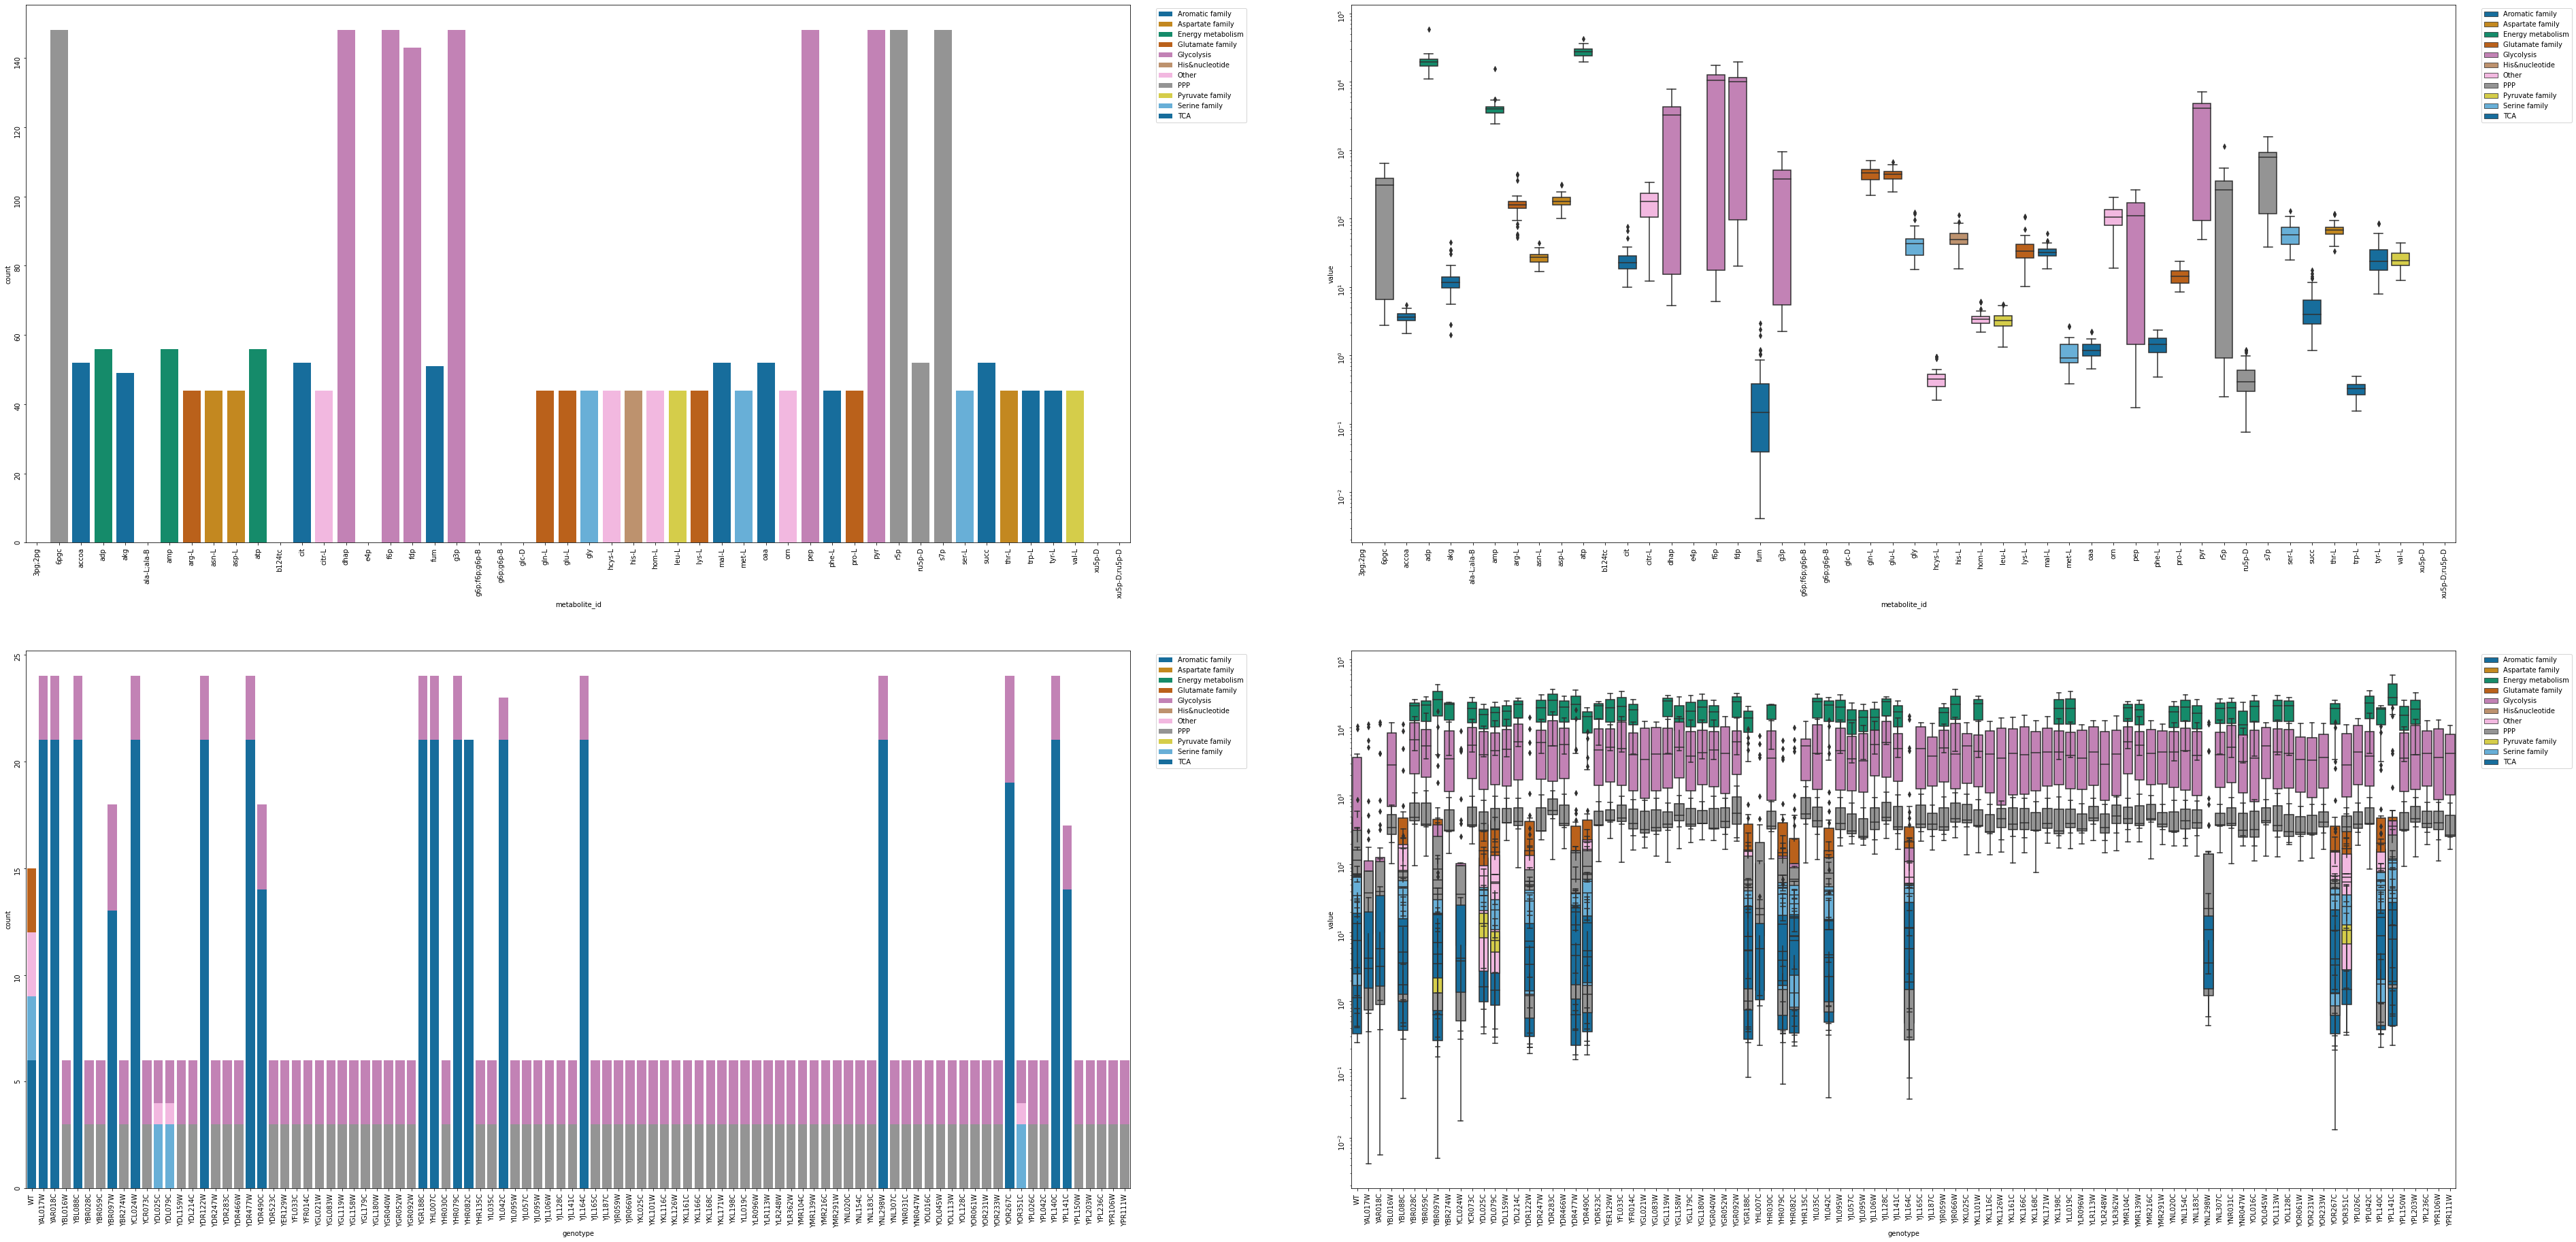

In [16]:
# we visualize some very simple statistics of the dataset
# we start by analysing the metabolites data
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(64, 32))

df = metabolites_df[metabolites_df['pathway'] != 'Unknown']

g = sns.countplot(
    x='metabolite_id',
    # y='adj.r.squared',
    hue='pathway',
    # order='pathway',
    data=df,
    ax=ax1,
    dodge=False,
    palette='colorblind',
    # order=df['pathway'].value_counts().index[::-1]
)

ax1.tick_params(labelrotation=90)
ax1.legend(bbox_to_anchor=(1.02, 1), loc='upper left')

sns.boxplot(
    x='metabolite_id',
    y='value',
    hue='pathway',
    data=df,
    ax=ax2,
    dodge=False,
    palette='colorblind',
)

ax2.tick_params(labelrotation=90)
ax2.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
ax2.set_yscale('log')

sns.countplot(
    x='genotype',
    hue='pathway',
    data=df,
    ax=ax3,
    dodge=False,
    palette='colorblind'
)

ax3.tick_params(labelrotation=90)
ax3.legend(bbox_to_anchor=(1.02, 1), loc='upper left')

sns.boxplot(
    x='genotype',
    y='value',
    hue='pathway',
    data=df,
    ax=ax4,
    dodge=False,
    palette='colorblind',
)

ax4.tick_params(labelrotation=90)
ax4.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
ax4.set_yscale('log')

plt.show()

In [32]:
mean_expression_per_knockout = proteins_df[
    (proteins_df['KO_ORF'].isin(metabolites_df['genotype']))
] \
    .groupby(['KO_gene_name', 'ORF'])['value'].mean() \
    .to_frame().pivot_table(index='ORF', columns='KO_gene_name', values='value')

sns.pairplot(
    data=mean_expression_per_knockout,
    diag_kind='kde'
)
    

KeyboardInterrupt: 

In [17]:
metabolites_df.groupby('genotype')['met_name'].value_counts()

genotype  met_name                  
WT        Unknown                       11
          Glycine                        3
          L-Arginine                     3
          L-Asparagine                   3
          L-Aspartate                    3
                                        ..
YPR111W   Glyceraldehyde 3-phosphate     1
          Phosphoenolpyruvate            1
          Pyruvate                       1
          Sedoheptulose 7-phosphate      1
          alpha-D-Ribose 5-phosphate     1
Name: met_name, Length: 1636, dtype: int64

In [18]:
a = proteins_df[
    (proteins_df['KO_ORF'].isin(metabolites_df['genotype']))
] \
    .merge(metabolites_df[['genotype', 'met_name', 'pathway']], left_on='KO_ORF', right_on='genotype', how='inner') \
    .groupby(['KO_ORF', 'ORF'])['value'].mean() \
    .to_frame() 
b = metabolites_df.groupby('genotype')['met_name'].value_counts().index.get_level_values(1).to_frame()
# pd.concat([a, b], ignore_index=True, axis=1)
    # .pivot_table(index=['pathway', 'met_name'], columns='genotype', values='value')

# proteins_df[
#     (proteins_df['KO_ORF'].isin(metabolites_df['genotype']))
# ] \
#     .groupby(['KO_ORF', 'ORF'])['value'].mean() \
#     .to_frame().pivot_table(index='ORF', columns='KO_ORF', values='value') 
    # .merge(metabolites_df[['genotype', 'met_name', 'pathway']], left_on='KO_ORF', right_on='genotype')

In [20]:
mean_expression_per_knockout = proteins_df[
    (proteins_df['KO_ORF'].isin(metabolites_df['genotype']))
] \
    .merge(metabolites_df[['genotype', 'met_name', 'pathway']], left_on='KO_ORF', right_on='genotype', how='inner') \
    .query("met_name != 'Unknown'") \
    .groupby(['pathway', 'KO_ORF', 'ORF'])['value'].mean() \
    .to_frame() \
    .pivot_table(index=['KO_ORF', 'ORF'], columns='pathway', values='value') \
    .fillna(0)
    

In [21]:
mean_expression_per_knockout

pathway          Aromatic family  Aspartate family  Energy metabolism  \
KO_ORF  ORF                                                             
WT      YAL003W         8.673124          8.673124                0.0   
        YAL005C         8.943694          8.943694                0.0   
        YAL007C         5.021576          5.021576                0.0   
        YAL012W         8.747461          8.747461                0.0   
        YAL035W         5.392658          5.392658                0.0   
...                          ...               ...                ...   
YPR111W YPR165W         0.000000          0.000000                0.0   
        YPR181C         0.000000          0.000000                0.0   
        YPR183W         0.000000          0.000000                0.0   
        YPR187W         0.000000          0.000000                0.0   
        YPR191W         0.000000          0.000000                0.0   

pathway          Glutamate family  Glycolysis  His&nucleotide     Other  \
KO_ORF  ORF                                                               
WT      YAL003W          8.673124    8.673124        8.673124  8.673124   
        YAL005C          8.943694    8.943694        8.943694  8.943694   
        YAL007C          5.021576    5.021576        5.021576  5.021576   
        YAL012W          8.747461    8.747461        8.747461  8.747461   
        YAL035W          5.392658    5.392658        5.392658  5.392658   
...                           ...         ...             ...       ...   
YPR111W YPR165W          0.000000    7.042098        0.000000  0.000000   
        YPR181C          0.000000    5.665398        0.000000  0.000000   
        YPR183W          0.000000    7.348864        0.000000  0.000000   
        YPR187W          0.000000    4.289903        0.000000  0.000000   
        YPR191W          0.000000    7.441776        0.000000  0.000000   

pathway               PPP  Pyruvate family  Serine family       TCA  
KO_ORF  ORF                                                          
WT      YAL003W  8.673124         8.673124       8.673124  8.673124  
        YAL005C  8.943694         8.943694       8.943694  8.943694  
        YAL007C  5.021576         5.021576       5.021576  5.021576  
        YAL012W  8.747461         8.747461       8.747461  8.747461  
        YAL035W  5.392658         5.392658       5.392658  5.392658  
...                   ...              ...            ...       ...  
YPR111W YPR165W  7.042098         0.000000       0.000000  0.000000  
        YPR181C  5.665398         0.000000       0.000000  0.000000  
        YPR183W  7.348864         0.000000       0.000000  0.000000  
        YPR187W  4.289903         0.000000       0.000000  0.000000  
        YPR191W  7.441776         0.000000       0.000000  0.000000  

[69696 rows x 11 columns]

In [22]:
reducer = umap.UMAP(
    n_neighbors=5,
    min_dist=0.3,
    metric='correlation'
)
scaler = StandardScaler()

scaled_expression = scaler.fit_transform(mean_expression_per_knockout.values)
embedding = reducer.fit_transform(scaled_expression)



<AxesSubplot:>

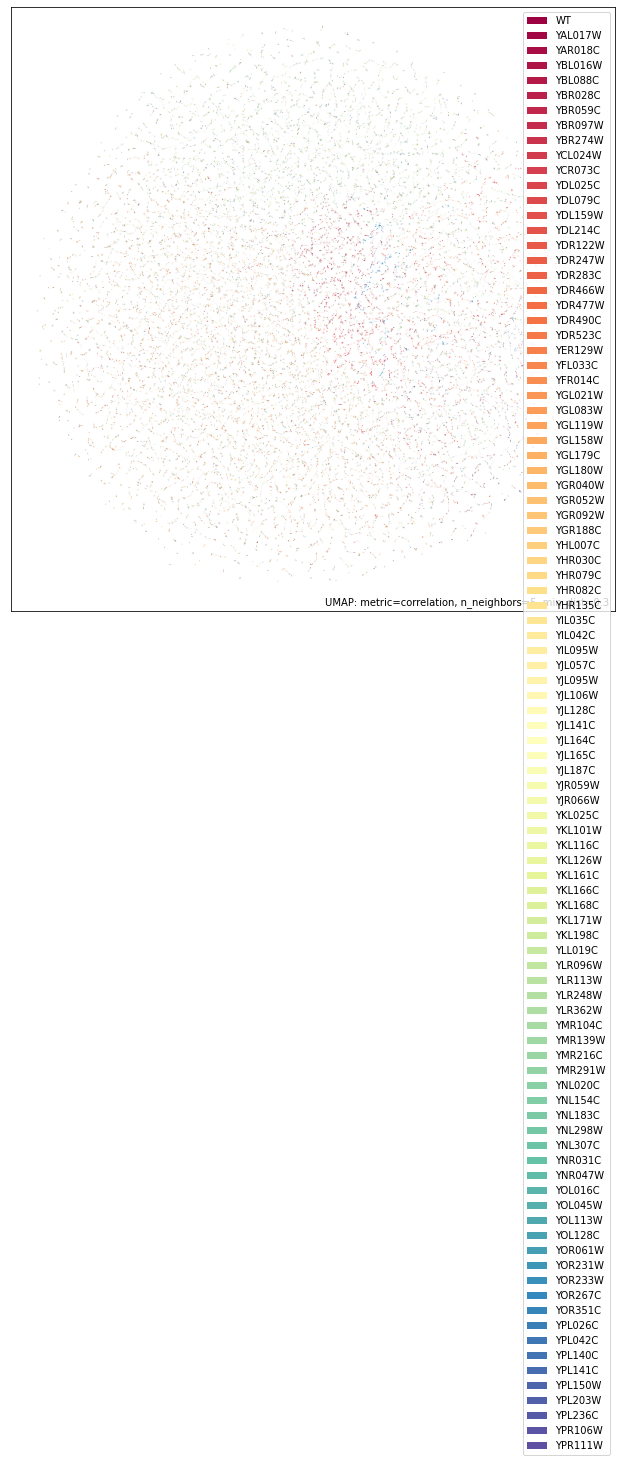

In [23]:
umap.plot.points(
    reducer,
    mean_expression_per_knockout.index.get_level_values(0)
)

In [10]:
df = raw_metabolites.merge(raw_proteins, left_on='genotype', right_on='KO_ORF')

In [11]:
df = raw_proteins[
    raw_proteins["KO_ORF"].isin(raw_metabolites['genotype'])
].groupby(by=['KO_ORF', 'ORF'])['value'].mean().transform(lambda x: np.log2(x)).to_frame().pivot_table(index='KO_ORF', columns='ORF', values='value')

diff_expressed_enzymes = df.iloc[1:] - df.iloc[0]

wt_metabolites = raw_metabolites[raw_metabolites['genotype'] == 'WT']['metabolite_id'].unique()
df = raw_metabolites[
    (raw_metabolites['metabolite_id'].isin(wt_metabolites))
]

df['value'] = df['value'].transform(lambda x: np.log2(x))
df = df.pivot_table(index='genotype', columns='metabolite_id', values='value')
diff_to_wt_meta = df.iloc[1:] - df.iloc[0]
df = diff_to_wt_meta.T.unstack(1).rename('meta_change').to_frame().reset_index().merge(diff_expressed_enzymes, left_on='genotype', right_on='KO_ORF')

diff_expressed_enzymes

/tmp/ipykernel_1092/3481186179.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['value'] = df['value'].transform(lambda x: np.log2(x))


ORF,YAL003W,YAL005C,YAL007C,YAL012W,YAL035W,YAL038W,YAL042W,YAL044C,YAR002C-A,YAR007C,...,YPR129W,YPR133C,YPR145W,YPR160W,YPR163C,YPR165W,YPR181C,YPR183W,YPR187W,YPR191W
KO_ORF,,,,,,,,,,,,,,,,,,,,,
YAL017W,-0.001724,-0.015140,0.033160,-0.011294,-0.021731,0.005452,-0.393861,0.022055,-0.045587,0.027340,...,-0.009357,-0.070945,0.046128,-0.055521,-0.000251,-0.046093,-0.013831,-0.024727,0.075281,-0.044966
YAR018C,0.017790,-0.061848,-0.005416,-0.040603,0.050090,0.018108,0.044935,0.083723,-0.013278,0.014316,...,0.045891,-0.014725,0.044635,-0.070358,-0.074966,0.005675,0.006765,0.004706,0.137208,-0.044369
YBL016W,-0.021557,-0.051508,-0.123918,0.054744,-0.563368,-0.102801,0.197982,0.228651,0.101341,0.084034,...,0.023554,0.164236,0.175555,-0.212236,-0.127275,-0.072379,-0.025990,0.077988,0.573968,-0.056929
YBL088C,0.002544,-0.030021,-0.012753,0.048740,-0.565576,-0.084588,-0.001584,0.081680,-0.009262,-0.036311,...,-0.036504,-0.209539,0.096788,-0.297094,-0.011931,-0.045398,-0.093384,0.061860,0.031216,-0.152670
YBR028C,-0.015099,-0.157559,-0.060817,0.022176,0.145094,0.021513,-0.065927,-0.004668,-0.038847,-0.013385,...,-0.079099,-0.021729,0.110726,-0.352181,-0.039678,-0.075014,0.002283,0.013617,-0.031740,-0.149110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YPL150W,0.042242,-0.158855,-0.046662,0.034316,-0.785206,-0.019543,-0.365845,0.073155,-0.039937,-0.027050,...,-0.102177,-0.247262,0.147746,-0.278432,-0.016697,-0.084313,-0.019979,0.034682,0.083971,-0.201764
YPL203W,-0.038621,-0.064514,-0.006182,-0.033504,-0.029733,0.030898,-0.117283,0.051425,0.008793,0.056961,...,-0.054134,-0.432949,0.034139,-0.102661,-0.099293,-0.074494,0.012857,0.041142,0.142985,-0.085312
YPL236C,-0.053729,-0.071925,-0.093287,0.033571,-0.295738,-0.007034,-0.111528,0.036988,0.031659,-0.003273,...,-0.004715,-0.537680,0.090698,-0.508648,0.041570,-0.027348,-0.020393,0.021500,0.011195,-0.204618


### UMAP analysis of integration

In [12]:
df = raw_proteins[
    raw_proteins["KO_ORF"].isin(raw_metabolites['genotype'])
].groupby(by=['KO_ORF', 'ORF'])['value'].mean().transform(lambda x: np.log2(x)).to_frame().pivot_table(index='KO_ORF', columns='ORF', values='value')

diff_expressed_enzymes = df.iloc[1:] - df.iloc[0]

wt_metabolites = raw_metabolites[raw_metabolites['genotype'] == 'WT']['metabolite_id'].unique()
df = raw_metabolites[
    (raw_metabolites['metabolite_id'].isin(wt_metabolites))
]

df['value'] = df['value'].transform(lambda x: np.log2(x))
df = df.pivot_table(index='genotype', columns='metabolite_id', values='value')
diff_to_wt_meta = df.iloc[1:] - df.iloc[0]
df = diff_to_wt_meta.T.unstack(1).rename('meta_change').to_frame().reset_index().merge(diff_expressed_enzymes, left_on='genotype', right_on='KO_ORF').dropna(axis=0)

targets = ['genotype', 'metabolite_id', 'meta_change']

/tmp/ipykernel_1092/4167516597.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['value'] = df['value'].transform(lambda x: np.log2(x))


/home/tvangraft/tudelft/thesis/.env/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


<AxesSubplot:>

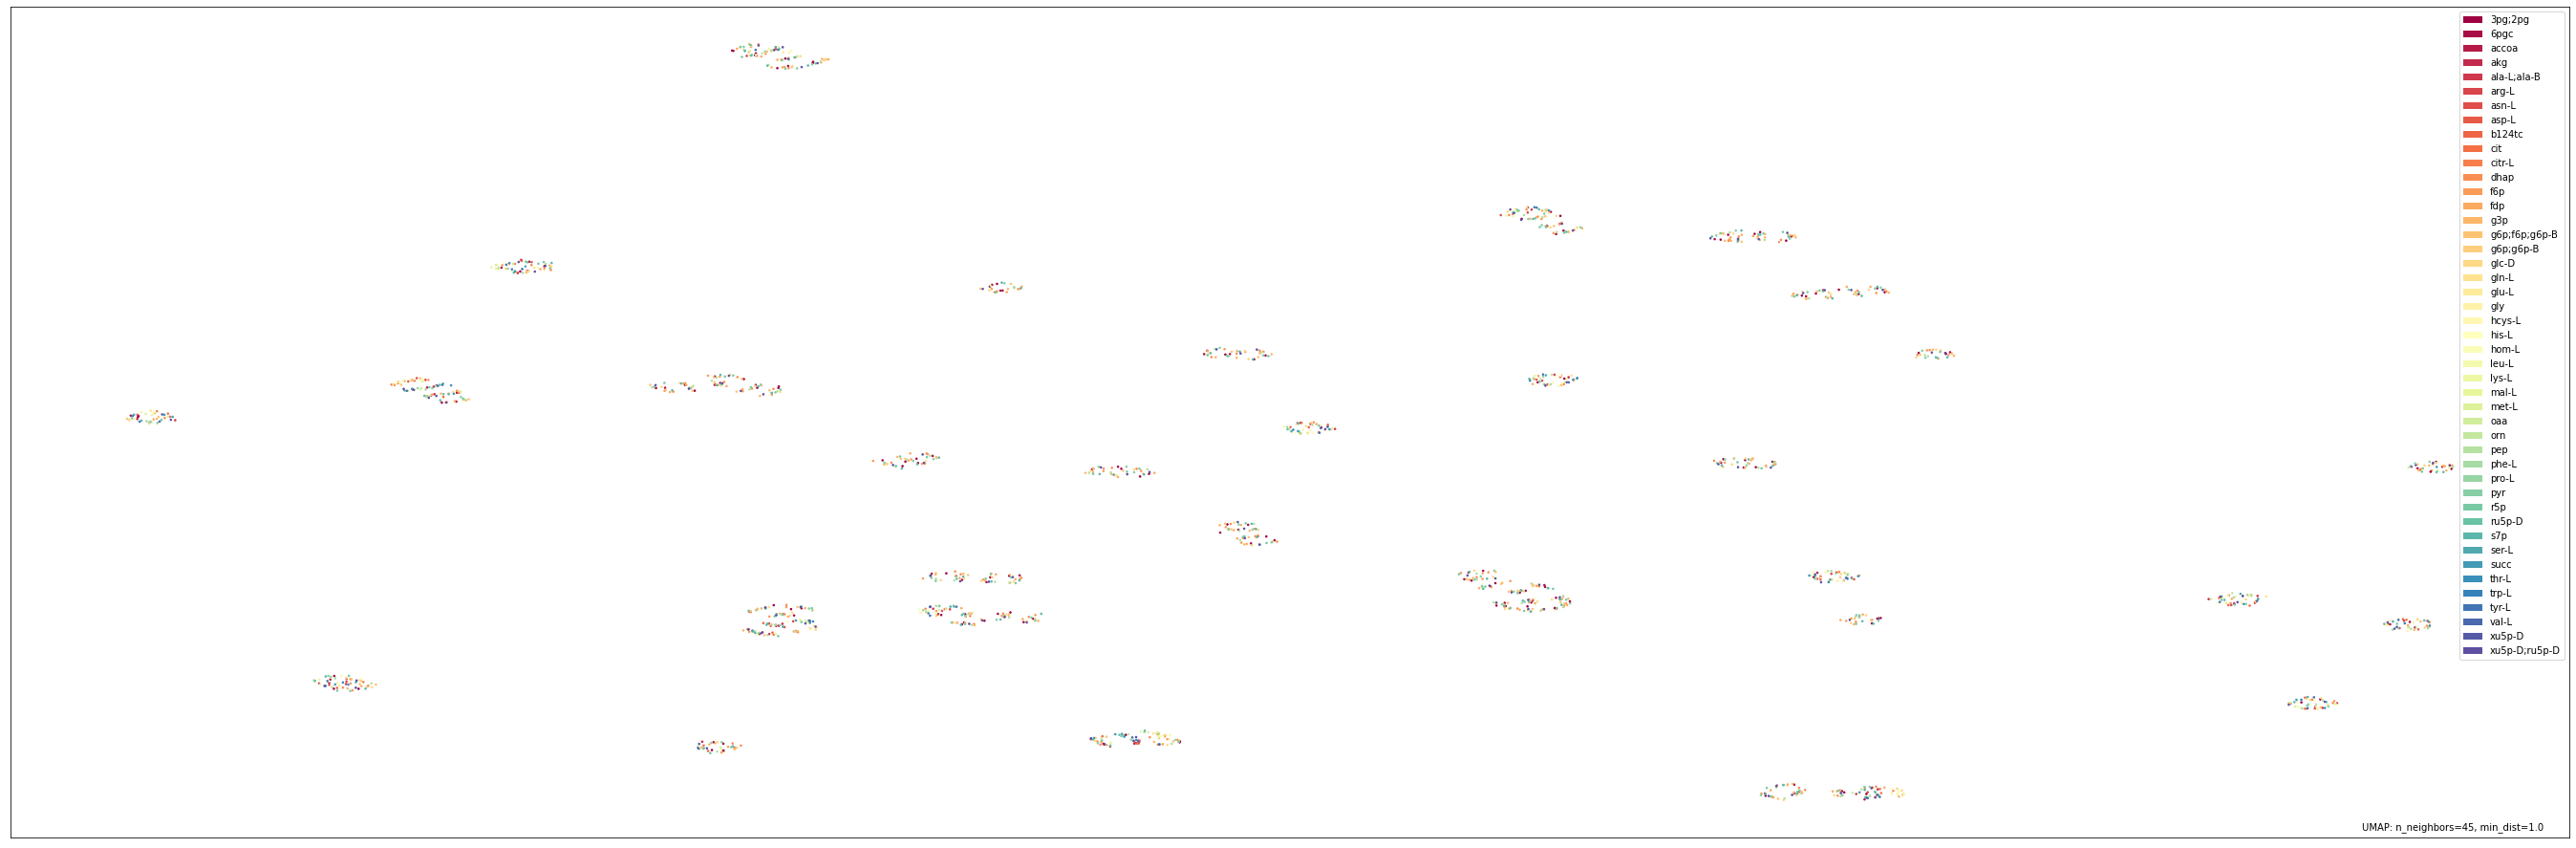

In [13]:
features = df.loc[:, ~df.columns.isin(targets)]

reducer = umap.UMAP(
    n_neighbors=len(df['metabolite_id'].unique()),
    metric='euclidean',
    min_dist=1.0
)
scaler = StandardScaler()

scaled_expression = scaler.fit_transform(features.values)
embedding = reducer.fit_transform(scaled_expression)

fig, ax = plt.subplots(1, 1, figsize=(48, 16))

umap.plot.points(
    reducer,
    df['metabolite_id'],
    ax=ax
)

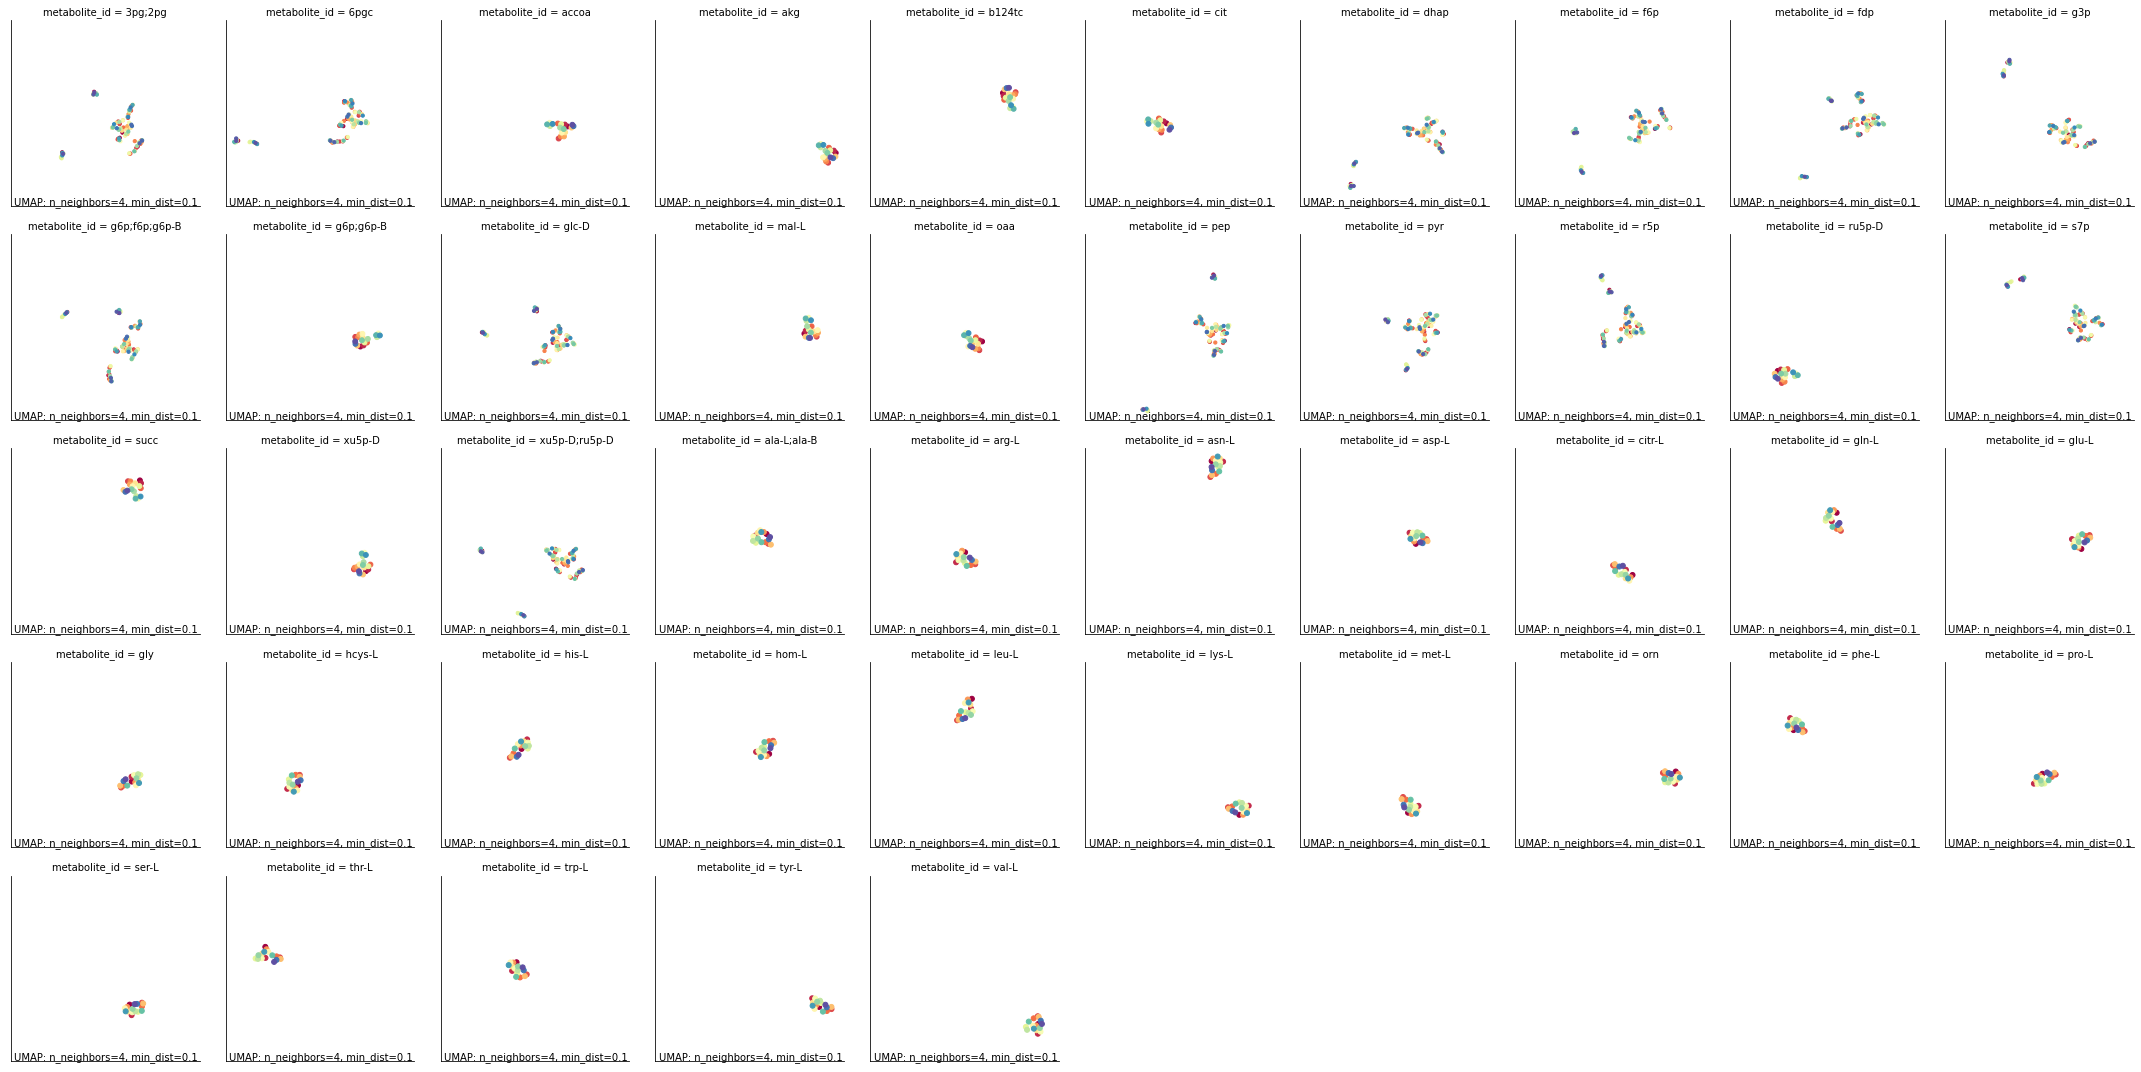

In [28]:
def mapper(*args, **kwargs):
    df = kwargs['data']
    features = df.loc[:, ~df.columns.isin(targets)]

    reducer = umap.UMAP(
        n_neighbors=4,
        metric='euclidean',
        min_dist=0.1
    )

    scaled_expression = StandardScaler().fit_transform(features.values)
    reducer.fit(scaled_expression)

    umap.plot.points(
        reducer,
        df['genotype'],
        ax=plt.gca(),
    )


g = sns.FacetGrid(df, col='metabolite_id', col_wrap=10)
g.map_dataframe(mapper)

### PCA analysis of integration

,genotype,metabolite_id,meta_change,YAL003W,YAL005C,YAL007C,YAL012W,YAL035W,YAL038W,YAL042W,...,YPR129W,YPR133C,YPR145W,YPR160W,YPR163C,YPR165W,YPR181C,YPR183W,YPR187W,YPR191W
0,YAL017W,3pg;2pg,-2.530063,-0.001724,-0.015140,0.033160,-0.011294,-0.021731,0.005452,-0.393861,...,-0.009357,-0.070945,0.046128,-0.055521,-0.000251,-0.046093,-0.013831,-0.024727,0.075281,-0.044966
1,YAL017W,6pgc,-1.812487,-0.001724,-0.015140,0.033160,-0.011294,-0.021731,0.005452,-0.393861,...,-0.009357,-0.070945,0.046128,-0.055521,-0.000251,-0.046093,-0.013831,-0.024727,0.075281,-0.044966
2,YAL017W,accoa,-0.211363,-0.001724,-0.015140,0.033160,-0.011294,-0.021731,0.005452,-0.393861,...,-0.009357,-0.070945,0.046128,-0.055521,-0.000251,-0.046093,-0.013831,-0.024727,0.075281,-0.044966
3,YAL017W,akg,0.098901,-0.001724,-0.015140,0.033160,-0.011294,-0.021731,0.005452,-0.393861,...,-0.009357,-0.070945,0.046128,-0.055521,-0.000251,-0.046093,-0.013831,-0.024727,0.075281,-0.044966
8,YAL017W,b124tc,-0.276759,-0.001724,-0.015140,0.033160,-0.011294,-0.021731,0.005452,-0.393861,...,-0.009357,-0.070945,0.046128,-0.055521,-0.000251,-0.046093,-0.013831,-0.024727,0.075281,-0.044966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4260,YPR111W,pep,4.062572,-0.023325,-0.052919,-0.030465,0.033469,-0.414988,-0.091205,0.037067,...,0.045508,-0.331802,0.034874,-0.331726,0.016716,0.008628,-0.078073,0.051957,0.105102,-0.090650
4263,YPR111W,pyr,3.239338,-0.023325,-0.052919,-0.030465,0.033469,-0.414988,-0.091205,0.037067,...,0.045508,-0.331802,0.034874,-0.331726,0.016716,0.008628,-0.078073,0.051957,0.105102,-0.090650
4264,YPR111W,r5p,4.140245,-0.023325,-0.052919,-0.030465,0.033469,-0.414988,-0.091205,0.037067,...,0.045508,-0.331802,0.034874,-0.331726,0.016716,0.008628,-0.078073,0.051957,0.105102,-0.090650
4266,YPR111W,s7p,1.637560,-0.023325,-0.052919,-0.030465,0.033469,-0.414988,-0.091205,0.037067,...,0.045508,-0.331802,0.034874,-0.331726,0.016716,0.008628,-0.078073,0.051957,0.105102,-0.090650


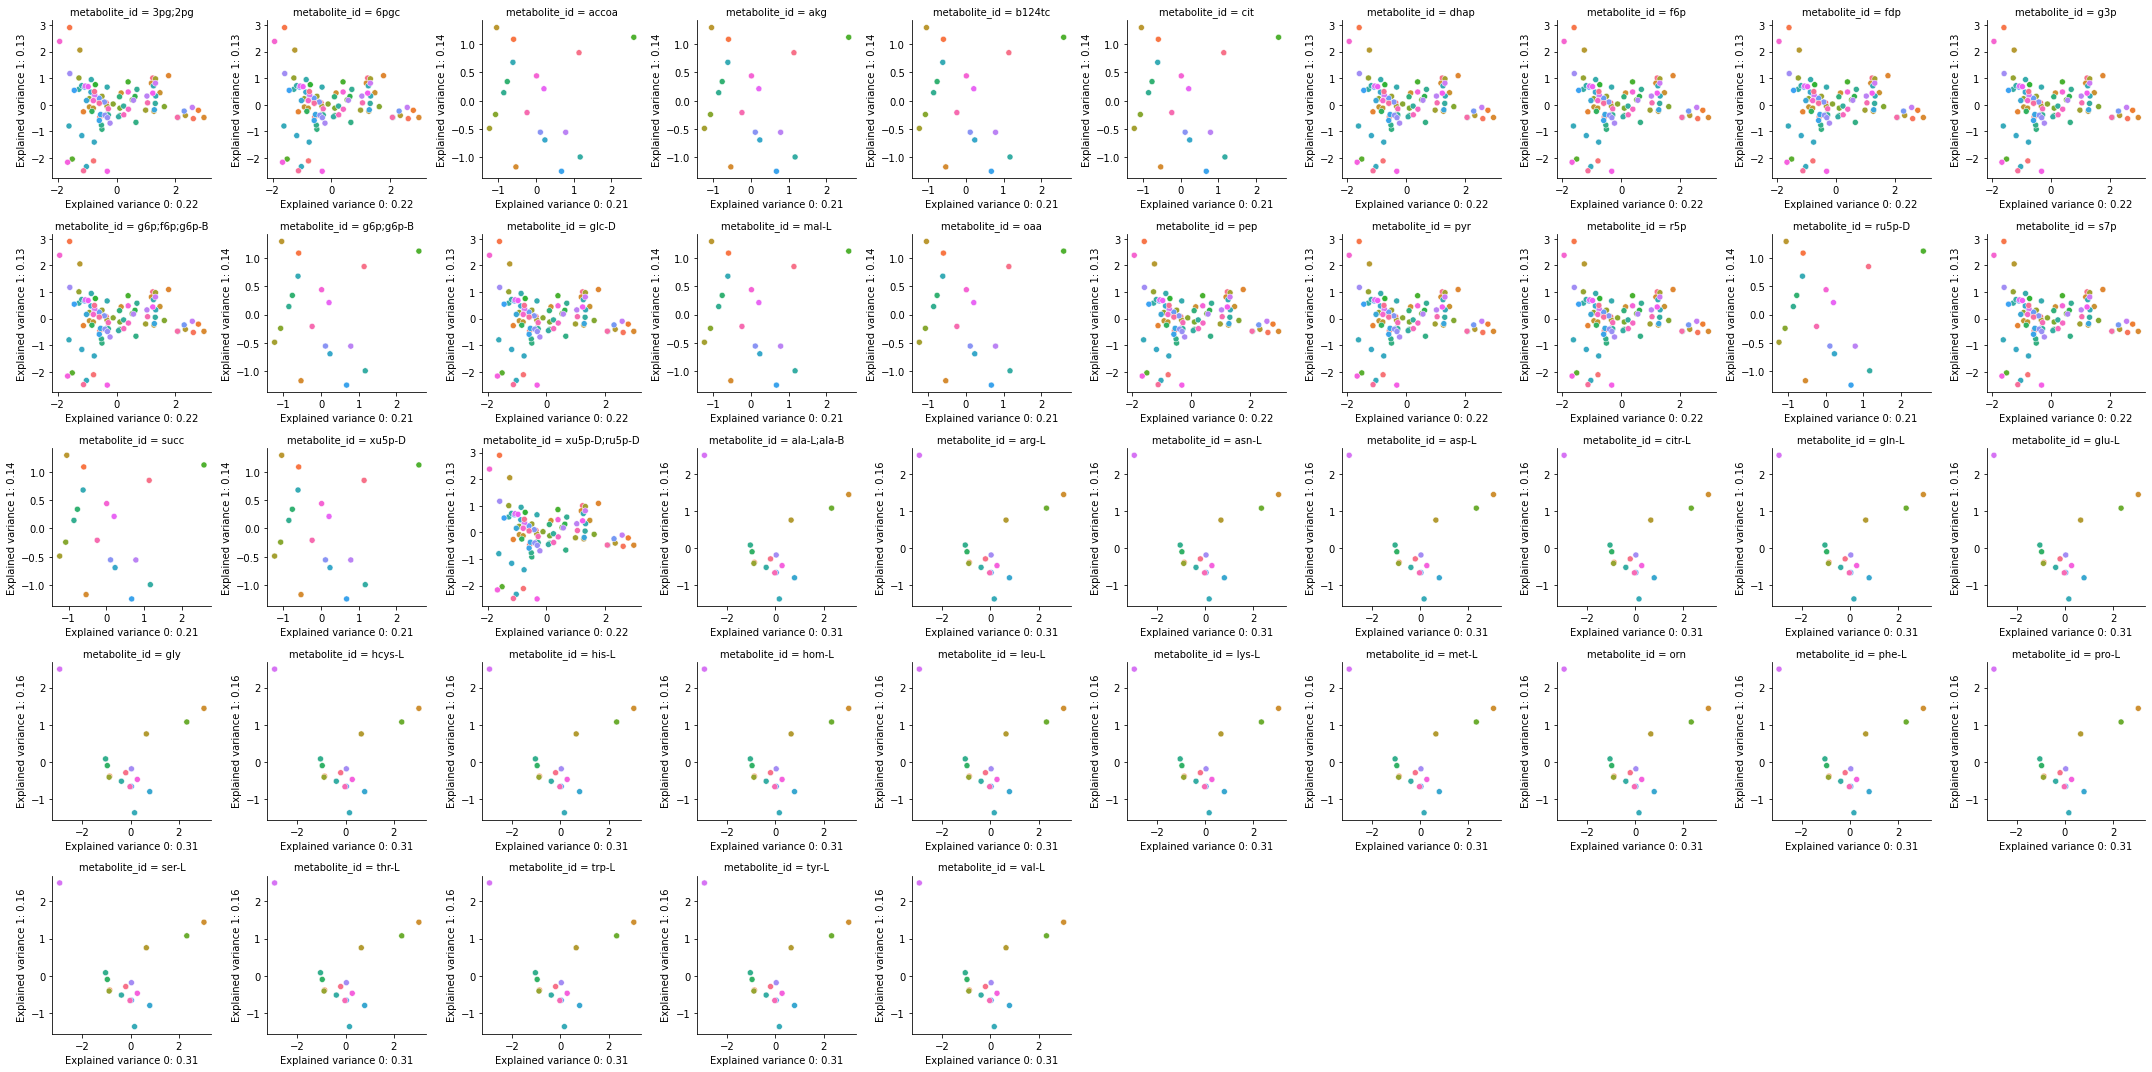

In [29]:
def mapper(*args, **kwargs):
    df = kwargs['data']
    pca = PCA(n_components=10)
    features = df.loc[:, ~df.columns.isin(targets)]

    embedding = pca.fit_transform(features.values)
    sns.scatterplot(
        x=embedding[:, 0],
        y=embedding[:, 1],
        hue=df['genotype'],
        ax=plt.gca()
    )

    plt.gca().set_xlabel(f'Explained variance 0: {pca.explained_variance_ratio_[0]:.2}')
    plt.gca().set_ylabel(f'Explained variance 1: {pca.explained_variance_ratio_[1]:.2}')


g = sns.FacetGrid(df, col='metabolite_id', col_wrap=10, sharex=False, sharey=False, legend_out=True)
g.map_dataframe(mapper)

df

### Metabolites distribution analysis

In [28]:
_df = LHS[precursor_metabolite_ids].stack().to_frame(name='metabolite_concentration').reset_index()
_df

,genotype,metabolite_id,metabolite_concentration
0,WT,g6p;g6p-B,50.625107
1,WT,g6p;f6p;g6p-B,14109.667929
2,WT,f6p,5248.663203
3,WT,dhap,1758.194055
4,WT,3pg;2pg,425.328812
...,...,...,...
798,YPR111W,3pg;2pg,710.438481
799,YPR111W,pep,166.737288
800,YPR111W,pyr,5226.804284
801,YPR111W,r5p,247.733497


In [32]:
_df_log_fc = _df.pivot_table(index='genotype', values='metabolite_concentration', columns='metabolite_id')
_df_log_fc.loc[:, _df_log_fc.columns] = np.log(_df_log_fc.loc[:, _df_log_fc.columns])
_df_log_fc = _df_log_fc - _df_log_fc.loc['WT'].values.squeeze()
_df_log_fc = _df_log_fc.drop('WT', axis=0)
_df_log_fc = _df_log_fc.unstack().to_frame(name='metabolite_concentration').reset_index()
_df_log_fc

,metabolite_id,genotype,metabolite_concentration
0,3pg;2pg,YAL017W,-1.033736
1,3pg;2pg,YAR018C,-0.772308
2,3pg;2pg,YBL016W,0.451764
3,3pg;2pg,YBL088C,-1.181897
4,3pg;2pg,YBR028C,0.952462
...,...,...,...
1135,r5p,YPL150W,0.761294
1136,r5p,YPL203W,0.906825
1137,r5p,YPL236C,0.718654
1138,r5p,YPR106W,0.466709


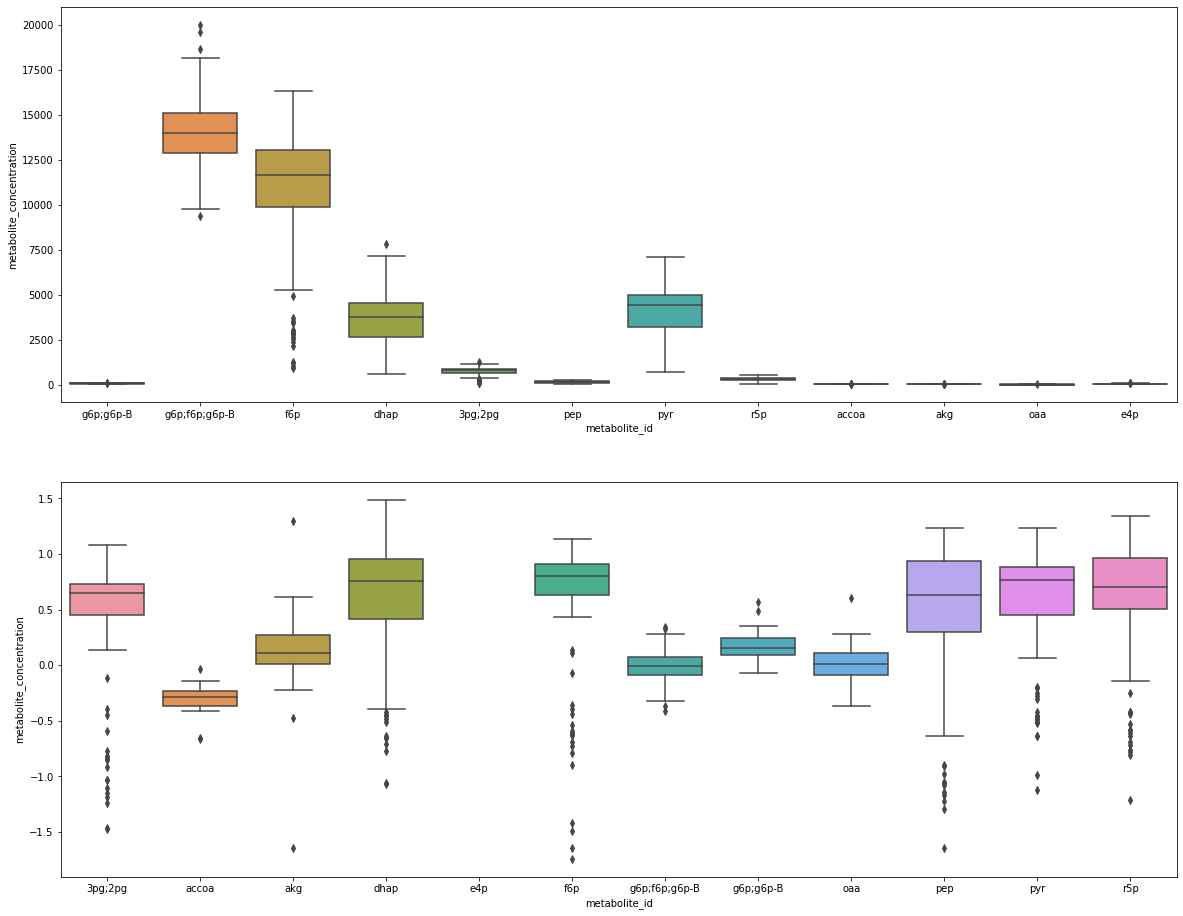

In [33]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(20, 16))

sns.boxplot(
    data=_df,
    x='metabolite_id',
    y='metabolite_concentration',
    ax=ax1
)

sns.boxplot(
    data=_df_log_fc,
    x='metabolite_id',
    y='metabolite_concentration',
    ax=ax2
)

plt.show()

/home/tvangraft/tudelft/thesis/.env/lib/python3.9/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


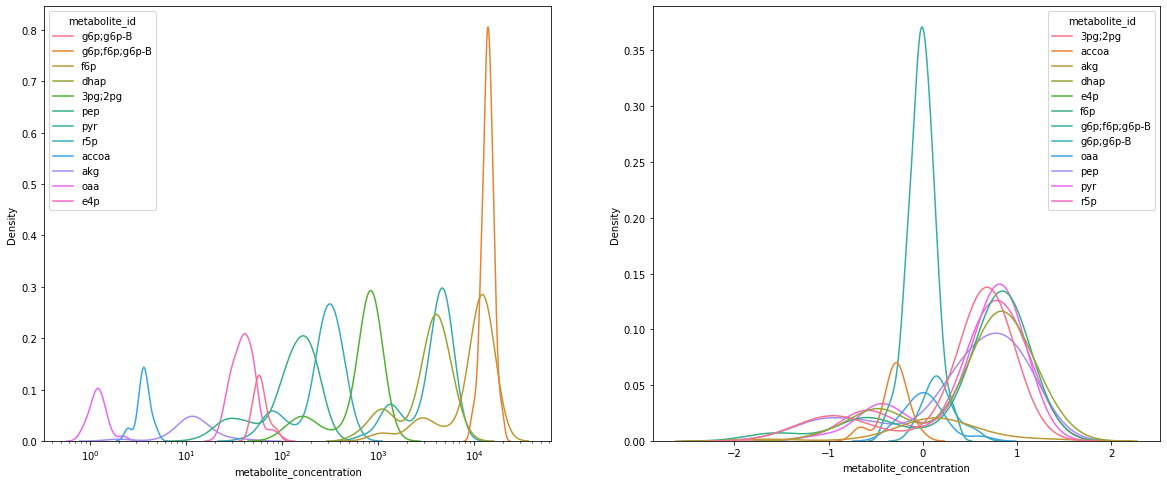

In [37]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 8))

sns.kdeplot(
    data=_df,
    x='metabolite_concentration',
    hue='metabolite_id',
    log_scale=(True),
    fill=False,
    ax=ax1
)

sns.kdeplot(
    data=_df_log_fc,
    x='metabolite_concentration',
    hue='metabolite_id',
    fill=False,
    ax=ax2
)

plt.savefig('./images/explorative/effect_of_log_fold_change_transformation.svg')
plt.savefig('./images/explorative/effect_of_log_fold_change_transformation.png')

In [ ]:
_df = _df.pivot_table(index='genotype', values='metabolite_concentration', columns='metabolite_id')
_df.loc[:, _df.columns] = np.log(_df.loc[:, _df.columns])
# for column in _df.columns:
#     _df.loc[:, column] = np.log(_df.loc[:, column])

_df = _df - _df.loc['WT'].values.squeeze()
_df = _df.drop('WT', axis=0)


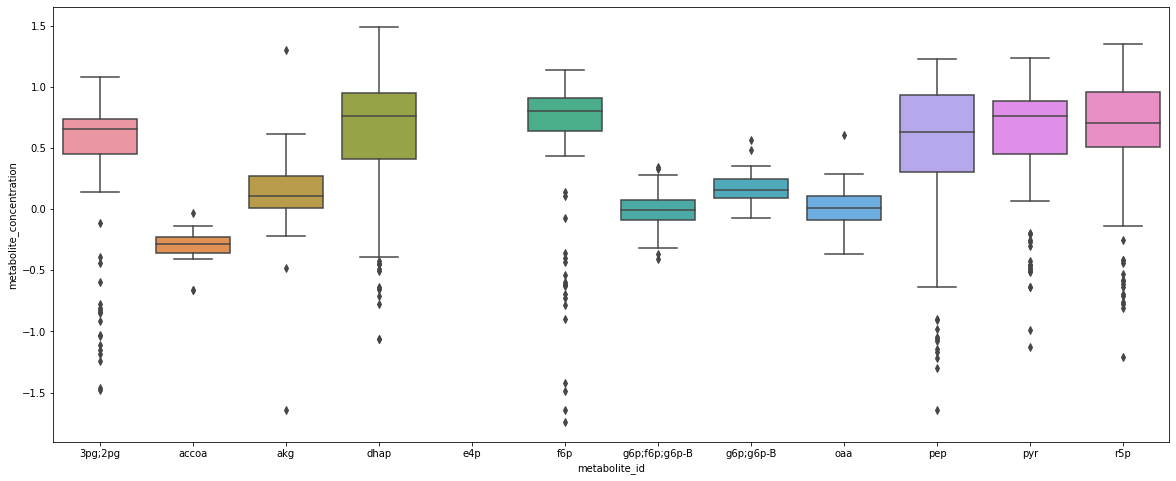

In [24]:
_df = _df.unstack().to_frame(name='metabolite_concentration').reset_index()
plt.figure(figsize=(20, 8))

sns.boxplot(
    data=_df,
    x='metabolite_id',
    y='metabolite_concentration',
)

plt.show()

/home/tvangraft/tudelft/thesis/.env/lib/python3.9/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


<Figure size 1440x1152 with 0 Axes>

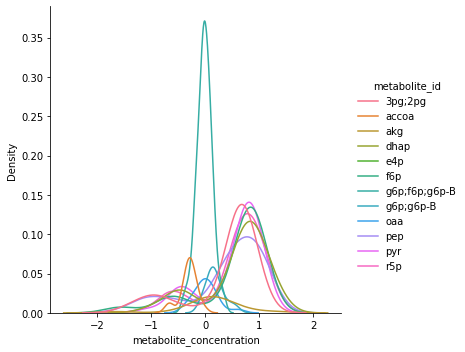

In [26]:
plt.figure(figsize=(20, 16))

sns.displot(
    data=_df,
    x='metabolite_concentration',
    hue='metabolite_id',
    # multiple='stack',
    # stat='probability',
    kind='kde',
    # common_norm=False,
    # y='metabolite_concentration',
    # log_scale=(True),
    fill=False,
    # multiple='stack'
)
